# Particle simulation vs Langevin model

In [34]:
using ProgressMeter
using Revise
using JLD2

In [35]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist
using DifferentialEquations, Distributions

## Growing population

### Parameters

In [36]:
using Plots
# plotly()
gr()
# plotlyjs()
# pyplot()

Plots.GRBackend()

In [37]:
using LaTeXStrings

In [38]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
    arenaParams["E"] = arenaParams["speed"]^2/2
end

extendParams! (generic function with 1 method)

In [39]:
arenaParams = 
    Dict(
        "n0"=>100,
        "evolveTime"=>4500,
        "bounds"=>((0.,10.),(0.,10.)), 
        "radius"=>0.08, 
        "speed"=>0.02,
        "timeStep"=> 0.1
    )

growthParams =
    Dict(
        "ρ"=> 0.005,
        "k"=> 1000,
        "randGrowth"=> false,
        "waitTime"=> 500
    )

extendParams!(arenaParams)

display(arenaParams)
display(growthParams)

function fillDensity(arenaParams, growthParams)  
    xperiod = abs(arenaParams["bounds"][1][2] - arenaParams["bounds"][1][1])
    yperiod = abs(arenaParams["bounds"][2][2] - arenaParams["bounds"][2][1])
    n0 = arenaParams["n0"]
    nT = growthParams["k"]
    r = arenaParams["radius"]
    V = xperiod*yperiod
    fillDens0 = n0*π*r^2 / V
    fillDensT = nT*π*r^2 / V
    return fillDens0, fillDensT
end

volumeDens(n, r, V) = n*π*r^2/V

timeSteps = arenaParams["timeStep"]:arenaParams["timeStep"]:arenaParams["evolveTime"]

println("t0 density: ", fillDensity(arenaParams, growthParams)[1])
println("t0 density: ", fillDensity(arenaParams, growthParams)[2])

Dict{String,Any} with 9 entries:
  "volume"     => 100.0
  "evolveTime" => 4500
  "speed"      => 0.02
  "radius"     => 0.08
  "timeStep"   => 0.1
  "E"          => 0.0002
  "bounds"     => ((0.0, 10.0), (0.0, 10.0))
  "bperiod"    => [10.0, 10.0]
  "n0"         => 100

Dict{String,Real} with 4 entries:
  "waitTime"   => 500
  "k"          => 1000
  "ρ"          => 0.005
  "randGrowth" => false

t0 density: 0.02010619298297468
t0 density: 0.20106192982974677


### Logistic Growth

The number of cells in the system increases according to the logistic growth function:
\begin{equation}
n(t) = \frac{k}{ 1 + \frac{k-n_0}{n_0}e^{-\rho t}}
\end{equation}


### Mean Free Path and Friction

In [40]:
nCells_t = Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            growthParams["ρ"], growthParams["k"], arenaParams["n0"]);

mfpTheory_t = (x -> Theorist.meanFreePath(x, 4*arenaParams["radius"])).(nCells_t);
frictionTheory_t = ( l -> Theorist.friction(l, arenaParams["E"]) ).(mfpTheory_t);

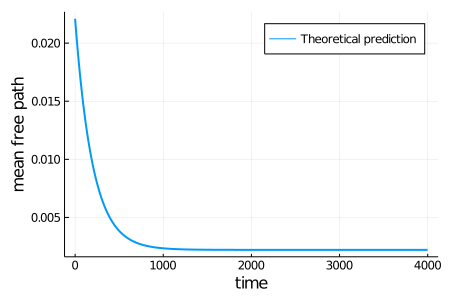

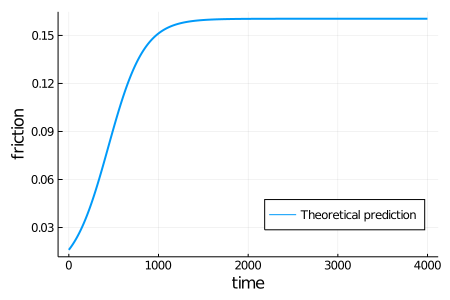

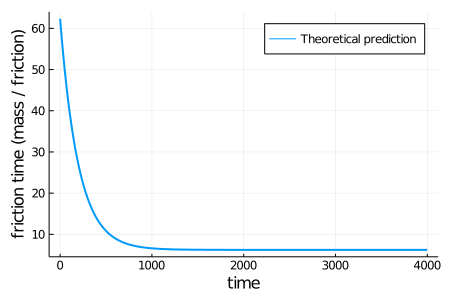

In [41]:
f2 = plot(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), mfpTheory_t,
        label="Theoretical prediction",
        linewidth=2,
        legend=:topright,
        size=(450,300))
xlabel!("time")
ylabel!("mean free path")
display(f2)

savefig(f2, "../Figures/rho"*string(growthParams["ρ"])*"mfp_time.pdf")

f3 = plot(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            arenaParams["speed"]*frictionTheory_t,
        label="Theoretical prediction",
        linewidth=2,
        legend=:bottomright,
        size=(450,300))
xlabel!("time")
ylabel!("friction")
display(f3)

savefig(f3, "../Figures/rho"*string(growthParams["ρ"])*"friction_time.pdf")

f4 = plot(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1),
            1 ./ (arenaParams["speed"]*frictionTheory_t),
        label="Theoretical prediction",
        linewidth=2,
#         legend=:bottomright,
        size=(450,300))
xlabel!("time")
ylabel!("friction time (mass / friction)")
display(f4)

savefig(f4, "../Figures/rho"*string(growthParams["ρ"])*"frictionTime_time.pdf")

Run Langevin simulations:

In [42]:
@time langevinEnsemble = Theorist.runLangevinSims(5000, arenaParams, growthParams);

Energy: 0.0002
245.603521 seconds (5.32 G allocations: 88.964 GiB, 41.08% gc time)


Run a particle simulation:

In [43]:
# @time arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID, times_t = 
#         BParts.randArenaEvolve(
#             arenaParams["n0"], 
#             arenaParams["evolveTime"],
#             arenaParams["timeStep"],
#             arenaParams,
#             growthParams,
#             verbose=true);

In [44]:
# msdPart0_t = BParts.meanSquaredDisplacement(pos_t_dim_id, msdTimes)

In [45]:
# f1 = plot(0:(arenaParams["evolveTime"]-1-growthParams["waitTime"]), 
#         volumeDens.(
#             Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
#             growthParams["ρ"], growthParams["k"], arenaParams["n0"]),
#             arenaParams["radius"],
#             arenaParams["volume"]
#         ),
#         label="growth function",
#         linewidth=2,
#         size=(450,300),
#         legend=:topleft)
# plot!(times_t .- growthParams["waitTime"], 
#     volumeDens.(
#         BParts.nCellsTime(cells_T_ID)[1:end],     
#         arenaParams["radius"],
#         arenaParams["volume"]
#     ),
#     label="particle simulation",
#     linewidth=2,
#     linestyle=:dash)
# xlabel!("time")
# ylabel!("occupied surface density")
# xlims!(0,arenaParams["evolveTime"]-growthParams["waitTime"])
# display(f1)

# savefig(f1, "../Figures/rho"*string(growthParams["ρ"])*"surfaceDensity_time.pdf")

Ensemble of particle simulations:

In [ ]:
nSims = 50

pos_Sim = Array{Array{Union{Float64, Missing},3}}(undef, nSims)
@showprogress for i in 1:nSims
    succes = false
    while !succes 
        # try/catch construction in case boundserror occurs
        try
            @time _, posSim_t_dim_id, __, ___ = 
                BParts.randArenaEvolve(
                        arenaParams["n0"],
                        arenaParams["evolveTime"], 
                        arenaParams["timeStep"],
                        arenaParams,
                        growthParams,
                        progress=false,
                        verbose=true);
            pos_Sim[i] = posSim_t_dim_id
#             println("sim: ", i)
        catch e
#             println("fail")
            continue
        end
        succes = true
    end
end

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
321.281303

Progress:   2%|▉                                        |  ETA: 4:22:28

 seconds (526.68 M allocations: 21.920 GiB, 3.83% gc time)
Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 20.402638044468123 found in time step0.1
anomalous collision time 5.110148568376719 found in time step0.1
anomalous collision time 6.252678635144586 found in time step0.1
anomalous collision time 0.17383961357978492 found in time step0.1
anomalous collision time 0.17383961357978492 found in time step0.1
anomalous collision time 19.403171668998013 found in time step0.1
anomalous collision time 1.4531171097113689 found in time step0.1
anomalous collision time 1.295893798469257 found in time step0.1
anomalous collision time 8.364203872062575 found in time step0.1
anomalous collision time 8.364203872062571 found in time step0.1
anomalous collision time 0.48742136113916423 found in time step0.1
anomalous collision time 8.364203872062575 found in time step0.1
anomalous collision time 2.5061

Progress:   4%|█▋                                       |  ETA: 4:13:47

312.984718 seconds (523.20 M allocations: 21.751 GiB, 3.12% gc time)
Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999993
anomalous collision time 0.10596999970055491 found in time step0.1
anomalous collision time 9.416547831447119 found in time step0.1
anomalous collision time 8.73946734043132 found in time step0.1
anomalous collision time 5.014941751487005 found in time step0.1
anomalous collision time 87.23032908741892 found in time step0.1
anomalous collision time 8.73946734043132 found in time step0.1
anomalous collision time 98.31268004372097 found in time step0.1
anomalous collision time 8.73946734043132 found in time step0.1
anomalous collision time 3.155283231387265 found in time step0.1
anomalous collision time 0.641518388471887 found in time step0.1
anomalous collision time 98.3126800437209 found in time step0.1
Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energ

Progress:   6%|██▌                                      |  ETA: 4:43:16

313.124059 seconds (523.67 M allocations: 21.769 GiB, 2.77% gc time)
Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
312.224058

Progress:   8%|███▎                                     |  ETA: 4:27:47

 seconds (523.50 M allocations: 21.762 GiB, 3.14% gc time)
Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000014
anomalous collision time 1.0822330623954022 found in time step0.1
anomalous collision time 15.90642726119279 found in time step0.1
anomalous collision time 1.2804158630204185 found in time step0.1
anomalous collision time 16.9498081846455 found in time step0.1
anomalous collision time 83.38415123884023 found in time step0.1
anomalous collision time 94.81911345876118 found in time step0.1
anomalous collision time 15.332159638692906 found in time step0.1
anomalous collision time 7.965393316477008 found in time step0.1
anomalous collision time 31.380365779288457 found in time step0.1
anomalous collision time 10.543312658287068 found in time step0.1
anomalous collision time 12.510555270446442 found in time step0.1
anomalous collision time 4.991105159853535 found in time step0.1
anomalous collision time 3.86153080

Progress:  10%|████▏                                    |  ETA: 4:16:14

 seconds (522.82 M allocations: 21.734 GiB, 3.12% gc time)
Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 3.997231025914431 found in time step0.1
anomalous collision time 5.223174541125462 found in time step0.1
anomalous collision time 4.050223033571151 found in time step0.1
anomalous collision time 0.25461458097618017 found in time step0.1
anomalous collision time 7.564418943502803 found in time step0.1
anomalous collision time 15.090253371304684 found in time step0.1
anomalous collision time 6.413131263969474 found in time step0.1
anomalous collision time 7.904068796828073 found in time step0.1
anomalous collision time 7.564418943502821 found in time step0.1
anomalous collision time 13.057153000171017 found in time step0.1
anomalous collision time 6.593840276997354 found in time step0.1
anomalous collision time 7.072791544851426 found in time step0.1
anomalous collision time 12.32386139034744 found in 

Progress:  12%|████▉                                    |  ETA: 4:06:50

 seconds (522.57 M allocations: 21.725 GiB, 3.15% gc time)
Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 0.11659287702523796 found in time step0.1
anomalous collision time 5.758490539548415 found in time step0.1
anomalous collision time 5.781337856083983 found in time step0.1
anomalous collision time 18.385829309049 found in time step0.1
anomalous collision time 5.122563997527174 found in time step0.1
anomalous collision time 42.992649045626614 found in time step0.1
Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 0.3313484322723349 found in time step0.1
anomalous collision time 0.4910618871174671 found in time step0.1
anomalous collision time 6.327523109995338 found in time step0.1
anomalous collision time 5.484575409675115 found in time step0.1
anomalous collision time 7.147616843197247 fou

Progress:  14%|█████▊                                   |  ETA: 4:34:57

315.480729 seconds (522.66 M allocations: 21.725 GiB, 3.80% gc time)
Building arena...
7 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000014
311.226662

Progress:  16%|██████▌                                  |  ETA: 4:22:13

 seconds (523.03 M allocations: 21.738 GiB, 3.09% gc time)
Building arena...
6 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 0.5156283875606988 found in time step0.1
anomalous collision time 12.861055340187084 found in time step0.1
anomalous collision time 0.8829696756876062 found in time step0.1
anomalous collision time 13.224829193911757 found in time step0.1
311.837246

Progress:  18%|███████▍                                 |  ETA: 4:11:13

 seconds (522.22 M allocations: 21.709 GiB, 3.11% gc time)
Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999987
anomalous collision time 0.6922108788877458 found in time step0.1
anomalous collision time 7.26819348902822 found in time step0.1
anomalous collision time 4.044456343217419 found in time step0.1
anomalous collision time 7.480039102810909 found in time step0.1
anomalous collision time 5.529228570880308 found in time step0.1
anomalous collision time 4.435136571826244 found in time step0.1
anomalous collision time 3.3520229447885193 found in time step0.1
anomalous collision time 2.5644498157482545 found in time step0.1
anomalous collision time 2.4439003386230356 found in time step0.1
anomalous collision time 16.520547549244625 found in time step0.1
anomalous collision time 16.52054754924462 found in time step0.1
anomalous collision time 2.287163710681738 found in time step0.1
311.469846 seconds (523.24 M allocat

Progress:  20%|████████▎                                |  ETA: 4:01:21

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999987
313.191194

Progress:  22%|█████████                                |  ETA: 3:52:26

 seconds (522.62 M allocations: 21.723 GiB, 3.21% gc time)
Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
310.196294

Progress:  24%|█████████▉                               |  ETA: 3:43:59

 seconds (523.24 M allocations: 21.754 GiB, 3.08% gc time)
Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999993
312.884292 seconds (523.01 M allocations: 21.743 GiB, 3.33% gc time)


Progress:  26%|██████████▋                              |  ETA: 3:36:10

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 87.80732763557435 found in time step0.1
anomalous collision time 0.2590225665616209 found in time step0.1
anomalous collision time 1.3831008208374698 found in time step0.1
anomalous collision time 112.4081813441528 found in time step0.1
anomalous collision time 0.9281206037299157 found in time step0.1
anomalous collision time 0.8716088431079707 found in time step0.1
anomalous collision time 8.754350585865144 found in time step0.1
anomalous collision time 7.239762902353337 found in time step0.1
anomalous collision time 5.2565182974033355 found in time step0.1
anomalous collision time 1.3921141396064698 found in time step0.1
anomalous collision time 5.914959085290702 found in time step0.1
anomalous collision time 9.349131795667994 found in time step0.1
anomalous collision time 9.880042103232263 found in time step0.1
anomalous collision time 9.4

Progress:  28%|███████████▌                             |  ETA: 3:37:32

310.340088 seconds (523.13 M allocations: 21.745 GiB, 2.77% gc time)
Building arena...
7 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
311.365599

Progress:  30%|████████████▎                            |  ETA: 3:29:31

 seconds (523.14 M allocations: 21.748 GiB, 3.10% gc time)
Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
312.035261

Progress:  32%|█████████████▏                           |  ETA: 3:21:51

 seconds (523.07 M allocations: 21.741 GiB, 3.08% gc time)
Building arena...
6 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
anomalous collision time 0.33906833975708006 found in time step0.1
anomalous collision time 4.546448519489033 found in time step0.1
anomalous collision time 0.6796663073195489 found in time step0.1
anomalous collision time 4.952060079000618 found in time step0.1
anomalous collision time 5.336004780946317 found in time step0.1
anomalous collision time 6.088850899964862 found in time step0.1
anomalous collision time 1.9662423714583457 found in time step0.1
anomalous collision time 7.600310345051826 found in time step0.1
anomalous collision time 16.967769648228735 found in time step0.1
anomalous collision time 6.551981519722643 found in time step0.1
anomalous collision time 9.632409367049675 found in time step0.1


Progress:  34%|██████████████                           |  ETA: 3:14:29

311.578524 seconds (523.32 M allocations: 21.752 GiB, 3.11% gc time)
Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
anomalous collision time 24.117133687737706 found in time step0.1
anomalous collision time 0.3216616897323919 found in time step0.1
anomalous collision time 5.9354539234801775 found in time step0.1
anomalous collision time 8.199444775621721 found in time step0.1
anomalous collision time 6.68864104985406 found in time step0.1
anomalous collision time 21.144898842796348 found in time step0.1
anomalous collision time 10.77195846228774 found in time step0.1
anomalous collision time 21.144898842796344 found in time step0.1
anomalous collision time 21.791212620868684 found in time step0.1
anomalous collision time 10.77195846228774 found in time step0.1
anomalous collision time 13.851150194301127 found in time step0.1
anomalous collision time 31.095506403323814 found in time step0.1
anomalous collision tim

Progress:  36%|██████████████▊                          |  ETA: 3:07:23

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000004
312.747899

Progress:  38%|███████████████▋                         |  ETA: 3:00:29

 seconds (523.52 M allocations: 21.760 GiB, 3.17% gc time)
Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
312.009060

Progress:  40%|████████████████▍                        |  ETA: 2:53:44

 seconds (522.78 M allocations: 21.728 GiB, 3.12% gc time)
Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02000000000000001
anomalous collision time 36.44293171762381 found in time step0.1
anomalous collision time 7.23336312146749 found in time step0.1
anomalous collision time 36.56234049690526 found in time step0.1
anomalous collision time 0.28798797674022253 found in time step0.1
anomalous collision time 5.57829423904175 found in time step0.1
anomalous collision time 32.55809665374309 found in time step0.1
anomalous collision time 17.758497352653485 found in time step0.1
anomalous collision time 2.3674181532606955 found in time step0.1
anomalous collision time 0.3462637415342549 found in time step0.1
anomalous collision time 7.358482398528556 found in time step0.1
anomalous collision time 22.88378116685808 found in time step0.1
anomalous collision time 6.655968259481587 found in time step0.1
anomalous collision time 5.44237200777

Progress:  42%|█████████████████▎                       |  ETA: 2:47:07

 seconds (523.34 M allocations: 21.749 GiB, 3.14% gc time)
Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
anomalous collision time 5.648268646895046 found in time step0.1
anomalous collision time 5.833541635958033 found in time step0.1
anomalous collision time 5.651195690163238 found in time step0.1
anomalous collision time 6.737479771254287 found in time step0.1
anomalous collision time 11.628221979694683 found in time step0.1
anomalous collision time 8.5873582730623 found in time step0.1
anomalous collision time 2.0790761220039413 found in time step0.1
anomalous collision time 11.319082418602923 found in time step0.1
anomalous collision time 4.525220407124685 found in time step0.1
anomalous collision time 54.898123633047476 found in time step0.1
anomalous collision time 7.5964493389322225 found in time step0.1
anomalous collision time 35.07834616413989 found in time step0.1
anomalous collision time 68.711979734

Progress:  44%|██████████████████                       |  ETA: 2:40:42

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 1.8822444736157236 found in time step0.1
anomalous collision time 8.426396583364403 found in time step0.1
anomalous collision time 7.09327465422341 found in time step0.1
anomalous collision time 2.9770475191625327 found in time step0.1
anomalous collision time 3.1439816036507726 found in time step0.1
anomalous collision time 2.0433844335927858 found in time step0.1
anomalous collision time 6.752239373103318 found in time step0.1
anomalous collision time 8.327726715111565 found in time step0.1
anomalous collision time 5.198746357623755 found in time step0.1
anomalous collision time 5.371212333916903 found in time step0.1
anomalous collision time 5.198746357623755 found in time step0.1
anomalous collision time 55.9778375675277 found in time step0.1
anomalous collision time 5.198746357623755 found in time step0.1
anomalous collision time 2.21203

Progress:  46%|██████████████████▉                      |  ETA: 2:34:21

312.911261 seconds (522.91 M allocations: 21.733 GiB, 3.40% gc time)
Building arena...
7 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
anomalous collision time 0.3917056160477785 found in time step0.1
anomalous collision time 7.080835709261566 found in time step0.1
anomalous collision time 9.947008134786113 found in time step0.1
anomalous collision time 2.3203281105754874 found in time step0.1
anomalous collision time 7.234550575060301 found in time step0.1
anomalous collision time 1.6576752301213011 found in time step0.1
anomalous collision time 0.9574645372319806 found in time step0.1
anomalous collision time 14.58019091627178 found in time step0.1
anomalous collision time 0.4608260308245899 found in time step0.1
anomalous collision time 44.44440393179589 found in time step0.1
anomalous collision time 0.4608260308245899 found in time step0.1
anomalous collision time 7.251015446691475 found in time step0.1
anomalous collision time

Progress:  48%|███████████████████▋                     |  ETA: 2:29:15

 seconds (523.46 M allocations: 21.756 GiB, 2.79% gc time)
Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.019999999999999997
Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 0.5424541744917609 found in time step0.1
anomalous collision time 6.864155860360116 found in time step0.1
anomalous collision time 7.34109663155275 found in time step0.1
anomalous collision time 3.4787377463978983 found in time step0.1
anomalous collision time 10.929283321401892 found in time step0.1
anomalous collision time 2.9797074466388596 found in time step0.1
anomalous collision time 10.929283321401899 found in time step0.1
anomalous collision time 1.0048582866881182 found in time step0.1
anomalous collision time 1.6663221730687996 found in time step0.1
anomalous collision time 3.098605571962706 found in time step0.1
anomalous collision time 6.323190731809124 found in time st

Progress:  50%|████████████████████▌                    |  ETA: 2:30:06

 seconds (522.96 M allocations: 21.737 GiB, 2.81% gc time)
Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
310.626002

Progress:  52%|█████████████████████▍                   |  ETA: 2:23:20

 seconds (523.07 M allocations: 21.740 GiB, 3.11% gc time)
Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.02
anomalous collision time 0.15517667089774587 found in time step0.1
anomalous collision time 4.981763150615385 found in time step0.1
anomalous collision time 5.0206070924384765 found in time step0.1
anomalous collision time 3.2992610095801655 found in time step0.1
anomalous collision time 5.5600668712813635 found in time step0.1
anomalous collision time 5.0206070924384685 found in time step0.1
anomalous collision time 12.006492935815297 found in time step0.1
anomalous collision time 4.288682704852689 found in time step0.1
anomalous collision time 3.676973801139813 found in time step0.1
anomalous collision time 3.563541085029958 found in time step0.1
anomalous collision time 3.8307098827073123 found in time step0.1
anomalous collision time 6.68968191881777 found in time step0.1
anomalous collision time 1.8492774721042313 found

Progress:  54%|██████████████████████▏                  |  ETA: 2:18:27

Building arena...
7 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.020000000000000007
311.731106

Progress:  56%|███████████████████████                  |  ETA: 2:11:47

### Mean squared displacement

In [ ]:
msdTimes = (growthParams["waitTime"]+1, arenaParams["evolveTime"])

In [ ]:
@time msd_Sim_t = (p_t_dim_id -> BParts.meanSquaredDisplacement(p_t_dim_id, msdTimes)).(pos_Sim);
msdPart_t = Array{Float64, 1}(undef, msdTimes[2]-msdTimes[1]+1)
for i in 1:(msdTimes[2]-msdTimes[1]+1)
    msdPart_t[i] = mean([ msd_tt[i] for msd_tt in msd_Sim_t ])
end

In [ ]:
length(msd_Sim_t[1])

In [ ]:
timesMSD_t, msdLan_t = 
    Theorist.msd(
        langevinEnsemble, 
        arenaParams,
        (growthParams["waitTime"]+1, arenaParams["evolveTime"])
    )

In [ ]:
saveName = "growingPop_multSims_rho"*string(growthParams["ρ"])*".jld2"

@save saveName arenaParams growthParams msd_Sim_t msdPart_t msdLan_t

In [ ]:
p2 = plot(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation", legend=:bottomright, linewidth=2,
    size=(400,300), 
    dpi=140)
plot!(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=2)
xlabel!(L"t")
ylabel!(L"\left\langle x(t)^2 \right\rangle")
# title!(latexstring("\\rho="*string(growthParams["ρ"])))
display(p2)

# savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.png")
savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.pdf")

In [ ]:
p2 = plot(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation", legend=:bottomright, linewidth=2,
    xaxis=:log10, yaxis=:log10,
    size=(400,300), 
    dpi=140)
plot!(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=2)
xlabel!(L"t")
ylabel!(L"\left\langle x(t)^2 \right\rangle")
title!(latexstring("\\rho="*string(growthParams["ρ"])))
display(p2)

# savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msdLoglog_time.png")
# savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msdLoglog_time.pdf")

## MSD linear regime

In [ ]:
# msdTimes = (arenaParams["evolveTime"]-1000, arenaParams["evolveTime"])

In [ ]:
# @time msd_Sim_t = (p_t_dim_id -> BParts.meanSquaredDisplacement(p_t_dim_id, msdTimes)).(pos_Sim);
# msdPart_t = Array{Float64, 1}(undef, msdTimes[2]-msdTimes[1]+1)
# for i in 1:(msdTimes[2]-msdTimes[1]+1)
#     msdPart_t[i] = mean([ msd_tt[i] for msd_tt in msd_Sim_t ])
# end

In [ ]:
# length(msd_Sim_t[1])

In [ ]:
# @time timesMSD_t, msdLan_t = 
#     Theorist.msd(
#         langevinEnsemble, 
#         arenaParams,
#         (arenaParams["evolveTime"]-1000, arenaParams["evolveTime"])
#     )
# # msdPar_t = BParts.meanSquaredDisplacement(pos_t_dim_id[1:msdTime,:,:], arenaParams["bperiod"]);

In [ ]:
# p2 = plot(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation", legend=:bottomright, linewidth=2,
#     size=(400,300), 
#     dpi=140)
# plot!(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=2)
# xlabel!(L"t")
# ylabel!(L"\left\langle x(t)^2 \right\rangle")
# # title!(latexstring("\\rho="*string(growthParams["ρ"])))
# display(p2)


In [ ]:
# msdSingles_Sim = []

# for sim in 1:nSims
#     msd_t = BParts.meanSquaredDisplacement(pos_Sim[sim], msdTimes)
#     push!(msdSingles_Sim, msd_t)
# end

In [ ]:
# p3 = plot(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=3,
#     legend=:topleft,
#     size=(500,300),
#     dpi=140)
# # plot!(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation average", linestyle=:dashdot, linewidth=3)
# # plot!(1:msdTimes[2]-msdTimes[1], msdPart0_t[2:end])
# for s in 1:nSims
#     plot!(1:msdTimes[2]-msdTimes[1], msdSingles_Sim[s][2:end],
# #         label="particle simulation "*string(s),
#         label="")
# end
# xlabel!(L"t")
# ylabel!(L"\left\langle x(t)^2 \right\rangle")
# # title!(latexstring("\\rho="*string(growthParams["ρ"])))
# display(p3)

# # savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.png")
# savefig(p3, "../Figures/rho"*string(growthParams["ρ"])*"msdSingles_time.pdf")

## Position monitor

In [ ]:
# pos_Sim[i] = posSim_t_dim_id
# cellID = 22

# p3 = plot(pos_Sim[4][:,1,1],pos_Sim[4][:,2,1], label="")
# for cellID in 2:100
#     plot!(pos_Sim[4][:,1,cellID],pos_Sim[4][:,2,cellID], label="")
# end

# display(p3)

In [ ]:
# simNumber = 3

# p3 = plot(pos_Sim[simNumber][:,1,1],pos_Sim[simNumber][:,2,1],
# #     dpi=300,
#     label="")
# for cellID in 2:50
#     plot!(pos_Sim[simNumber][:,1,cellID],pos_Sim[simNumber][:,2,cellID], label="")
# end

# display(p3)

# # savefig(p3, "singleTrajectories_Sim"*string(simNumber)*".png")

In [ ]:
# simNumber = 4

# p3 = plot(pos_Sim[simNumber][:,1,1],pos_Sim[simNumber][:,2,1],
# #     dpi=300,
#     label="")
# for cellID in 2:50
#     plot!(pos_Sim[simNumber][:,1,cellID],pos_Sim[simNumber][:,2,cellID], label="")
# end

# display(p3)

# # savefig(p3, "singleTrajectories_Sim"*string(simNumber)*".png")

In [ ]:
# simNumber = 1

# p3 = plot(pos_Sim[simNumber][:,1,1],pos_Sim[simNumber][:,2,1],
# #     dpi=300,
#     label="")
# for cellID in 2:50
#     plot!(pos_Sim[simNumber][:,1,cellID],pos_Sim[simNumber][:,2,cellID], label="")
# end

# display(p3)

# # savefig(p3, "singleTrajectories_Sim"*string(simNumber)*".png")

In [ ]:
# simNumber = 2

# p3 = plot(pos_Sim[simNumber][:,1,1],pos_Sim[simNumber][:,2,1],
# #     dpi=300,
#     label="")
# for cellID in 2:50
#     plot!(pos_Sim[simNumber][:,1,cellID],pos_Sim[simNumber][:,2,cellID], label="")
# end

# display(p3)

# # savefig(p3, "singleTrajectories_Sim"*string(simNumber)*".png")

In [ ]:
# simNumber = 5

# p3 = plot(pos_Sim[simNumber][:,1,1],pos_Sim[simNumber][:,2,1],
# #     dpi=300,
#     label="")
# for cellID in 2:50
#     plot!(pos_Sim[simNumber][:,1,cellID],pos_Sim[simNumber][:,2,cellID], label="")
# end

# display(p3)

# # savefig(p3, "singleTrajectories_Sim"*string(simNumber)*".png")